# Text Recognition

Based on my research around segmentation, manual cropping of images is the way to go. Therefore, using the same image in the series, it was manually split.

Text recognition, especially for print involves either:
1. Use of optical character recognition; [Tessaract](https://github.com/tesseract-ocr/tesseract) is an open-source OCR (Optical Character Recognition) software.
2. Use of out-of-the box machine learning like [Textract](https://aws.amazon.com/textract/), a product from Amazon that is part of its machine learning solutions.

## OCR Technology

### Installation on Server/CPU for Tesseract

The first step is to install Tessaract on your OS... 

In my case, I:
* installed [*Tessaract 5.0* for Windows](https://github.com/UB-Mannheim/tesseract/wiki) using [this guide](https://medium.com/quantrium-tech/installing-and-using-tesseract-4-on-windows-10-4f7930313f82) to work locally, and
* installed it in the cloud by running
    * the following command on Google Colab (Ubuntu): `!sudo apt install tesseract-ocr`
    * the following commands on Deepnote (Debian) terminal: `!sudo apt-get update` and then `!sudo apt install tesseract-ocr -y`

*N/B: For each session in the cloud, run the Tesseract installation commands in the cell/terminal.*

Python Tesseract wrappers for *Tesseract 4.0x*
* `tesserocr` - A Python wrapper around Tesseract’s C++ API (however, it does not work with *Tesseract 5.0*)
* `pytesseract` - a wrapper class for Tesseract OCR (requires tesseract executable)
* `tesseract-ocr-wrapper` - a python wrapper for tesseract-ocr with support for OCRing of pdf
* `aiopytesseract` - asyncio tesseract wrapper for Tesseract-OCR.


> *In python there are two most popular options: `PyTesseract` and `Tesserocr`.*
> *`Tesserocr` is a python wrapper around the Tesseract C++ API. On the other hand, `PyTesseract` is a wrapper for the tesseract-ocr CLI program.*
> *And as you can guess `Tesserocr` gives a lot more flexibility and control over tesseract. `Tesserocr` has multi-processing capabilities*
> *which are much faster in actual practise as compared to `PyTesseract`.*<br>
> &nbsp;- Analytics Vidhya

Once the tesseract engine is up and running, you can install `PyTesseract` with the following code: `!pip install pytesseract`

In [1]:
!pip install Pillow
!pip install numpy
!pip install opencv-python-headless
!pip install pythonRLSA
!pip install pytesseract

In [2]:
from PIL import Image # Pillow package
import cv2 # Open CV package
import numpy as np # Numpy package
import math
from pythonRLSA import rlsa
import pytesseract
import argparse

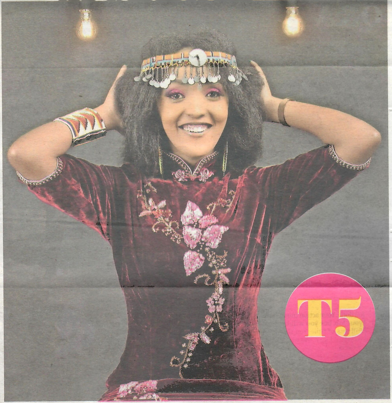

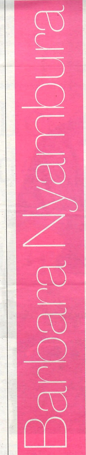

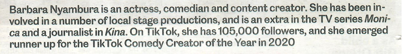

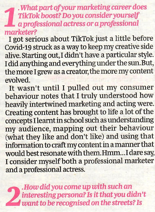

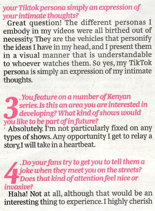

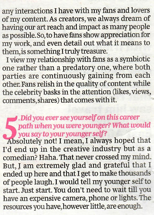

In [3]:
photo = {}

for i in range(6):
    try:
        sample_image_path = f"./kip-images/part{i}.jpg"
        photo[sample_image_path] = Image.open(sample_image_path)

    except:
        sample_image_path = f"/home/jovyan/book/kenyans-in-print/kip-images/part{i}.jpg"
        photo[sample_image_path] = Image.open(sample_image_path)


for key in photo:
    width, height = photo[key].size
    display(photo[key].resize(
        (int(width*0.2),int(height*0.2))
    ))
    print('')

## Obtain the larger text for each sub-image

From the images, there are taller elements; let's get the mask of each image that has that feature 

In [4]:
masks = {}
large_text = {}
new_photo = {}

for key in photo:
    gray = cv2.cvtColor(cv2.imread(key), cv2.COLOR_BGR2GRAY)
    (thresh, binary) = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY |
                                 cv2.THRESH_OTSU)
    (contours, _) = cv2.findContours(~binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        """
        draw a rectangle around those contours on main image
        """
        [x,y,w,h] = cv2.boundingRect(contour)
        cv2.rectangle(cv2.imread(key), (x,y), (x+w,y+h), (0, 255, 0), 1)
    
    mask = np.ones(cv2.imread(key).shape[:2], dtype="uint8") * 255 # create blank image of same dimension of the original image
    heights = [cv2.boundingRect(contour)[3] for contour in contours] # collecting heights of each contour
    
    avgheight = sum(heights)/len(heights) # average height
    
    # finding the larger contours
    # Applying Height heuristic
    for c in contours:
        [x,y,w,h] = cv2.boundingRect(c)
        if h > 2*avgheight:
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    x, y = mask.shape
    
    value = max(math.ceil(x/100),math.ceil(y/100))+20 #heuristic
    mask = rlsa.rlsa(mask, False, True, value) #rlsa application with rlsa vertical - "reads" the content top to bottom
    
    (contours, _) = cv2.findContours(~mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # find contours
    mask2 = np.ones(cv2.imread(key).shape, dtype="uint8") * 255 # blank 3 layer image
    
    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour)
        if w > 0.02*cv2.imread(key).shape[1]: # width heuristic applied; experimented until this number
            large = cv2.imread(key)[y: y+h, x: x+w]
            mask2[y: y+h, x: x+w] = large # copied title contour onto the blank image
            large_text[key] = mask2

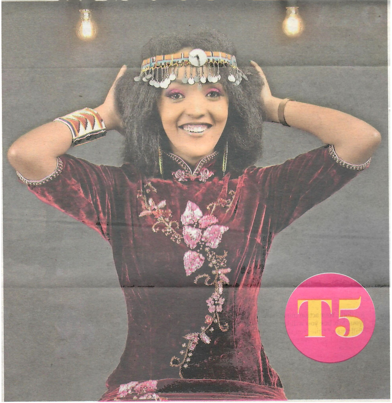

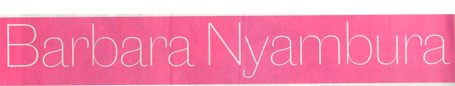

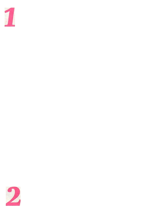

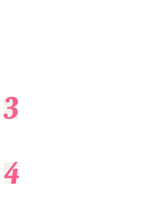

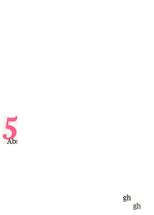

In [5]:
for key in large_text:
    p = cv2.cvtColor(large_text[key], cv2.COLOR_BGR2RGB)
    p = Image.fromarray(p)
    width, height = p.size
    display(p.resize(
        (int(width*0.2),int(height*0.2))
    ))
    print('')

## OCR vs. Machine Learning output

### 1. Raw text results from using PyTesseract

In [6]:
for key in photo:
    text = pytesseract.image_to_string(photo[key])
    print(text)
    print('---------------')


---------------
BINGLUCAN Brequeg
PS

---------------
Barbara Nyambura is an actress, comedian and content creator. She has been in-
volved ina number of local stage productions, and is an extra in the TV series Moni-
ca and a journalist in Kina. On TikTok, she has 105,000 followers, and she emerged
runner up for the TikTok Comedy Creator of the Year in 2020

---------------
TikTok boost? Do you consider yourself
aprofessional actress or a professional
marketer?

I got serious about TikTok just a little before
Covid-19 struck as a way to keep my creative side
alive. Starting out,I didn't have a particular style.
Idid anything and everything under the sun.But,
the more I grew as a creator, the more my content
evolved.

It wasn't until I pulled out my consumer
behaviour notes that I truly understood how
heavily intertwined marketing and acting were.
Creating content has brought to life a lot of the
concepts I learnt in school such as understanding
my audience, mapping out their behaviou

In [7]:
for key in large_text:
    p = cv2.cvtColor(large_text[key], cv2.COLOR_BGR2RGB)
    p = Image.fromarray(p)
    text = pytesseract.image_to_string(p)
    print(text)
    print('---------------')


---------------
ee
Barbara Nyambura


---------------

---------------

---------------

---------------


Strangely enough from the results above, the computer is struggling to identify the isolated large text, but gives pretty okay results from the original cropped images themselves.

### 2. Raw text results from using Textract

When running each cropped image (except the image) on their demo page, I got pretty good results as `.txt` files:

In [8]:
texts = {}
for i in range(1,6):
    try:
        sample_text_path = f"./kip-text/part{i}rawText.txt"
        file = open(sample_text_path, 'r')
        string = str(file.read())
        file.close()
        texts[sample_text_path] = string

    except:
        sample_text_path = f"/home/jovyan/book/kenyans-in-print/kip-text/part{i}rawText.txt"
        file = open(sample_text_path, 'r')
        string = str(file.read())
        file.close()
        texts[sample_text_path] = string

In [9]:
for key in texts:
    print(texts[key])
    print('---------------------------------------------')


Barbara Nyambura
---------------------------------------------

Barbara Nyambura is an actress, comedian and content creator. She has been in-
volved in a number of local stage productions, and is an extra in the TV series Moni-
ca and a journalist in Kina. On TikTok, she has 105,000 followers, and she emerged
runner up for the TikTok Comedy Creator of the Year in 2020
---------------------------------------------

0 What part of your marketing career does
1
TikTok boost? Do you consider yourself
a professional actress or a professional
marketer?
I got serious about TikTok just a little before
Covid-19 struck as a way to keep my creative side
alive. Starting out, I didn't have a particular style.
I did anything and everything under the sun. But,
the more I grew as a creator, the more my content
evolved.
It wasn't until I pulled out my consumer
behaviour notes that I truly understood how
heavily intertwined marketing and acting were.
Creating content has brought to life a lot of the
co

The results are pretty polished, no?

# References

* https://projectgurukul.org/python-text-detection-extraction-opencv-ocr/
* https://www.geeksforgeeks.org/text-localization-detection-and-recognition-using-pytesseract/
* https://stackoverflow.com/questions/8663680/opening-a-txt-file-in-python